# Econ 212: Homework 2

In [35]:
from scipy.optimize import fsolve
from sequence_jacobian import simple, create_model, solved
from sequence_jacobian.utilities.drawdag import drawdag
from statsmodels.tsa.filters.hp_filter import hpfilter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(12345)

## Question 1: Government Spending Shocks



### Part 3: Model calibration and simulation

## Question 2: Productivity News Shocks

### Part 1b: Impulse Response Functions, Baseline

In [3]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, b, delta):
    C = (w / b / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, euler, walras

@simple
def Z_process(Z, epsilon, epsilon_news, rho):
    epsilon_end = (Z).apply(np.log) - rho * (Z(-1)).apply(np.log) - epsilon_news(-4)
    epsilon_target = epsilon_end - epsilon
    return  epsilon_target 

In [9]:
alpha = 0.33
beta = 0.99
eta = 1.
delta = 0.02
b = 6.57
sigma = 0.01
rho = 0.9

Frisch = 1/eta
EIS = 1.

T = 250

In [11]:
rbc_1b = create_model([household, firm, mkt_clearing, Z_process], name="RBC_2_1b")


calibration = {"Z": 1., "eis": EIS, "frisch": Frisch, "alpha": 0.33,"epsilon": 0., "epsilon_news": 0., "rho": rho, "delta" : 0.02, "b": b, "beta" : 0.99}
unknowns_ss = {"K": 20., "L" : 0.33}
targets_ss = {"goods_mkt": 0., "euler": 0.}

ss_1b = rbc_1b.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")


inputs_1b = {"epsilon", "epsilon_news"}
unknowns_1b = {"K","L","Z"}
targets_1b = {"goods_mkt","euler","epsilon_target"}

G_1b = rbc_1b.solve_jacobian(ss_1b, unknowns_1b, targets_1b, inputs_1b, T=T)

In [21]:
VAR_LIST = ["Y", "L", "C", "I"]

In [22]:
deps_news = np.zeros(T)
deps_news[0] = sigma

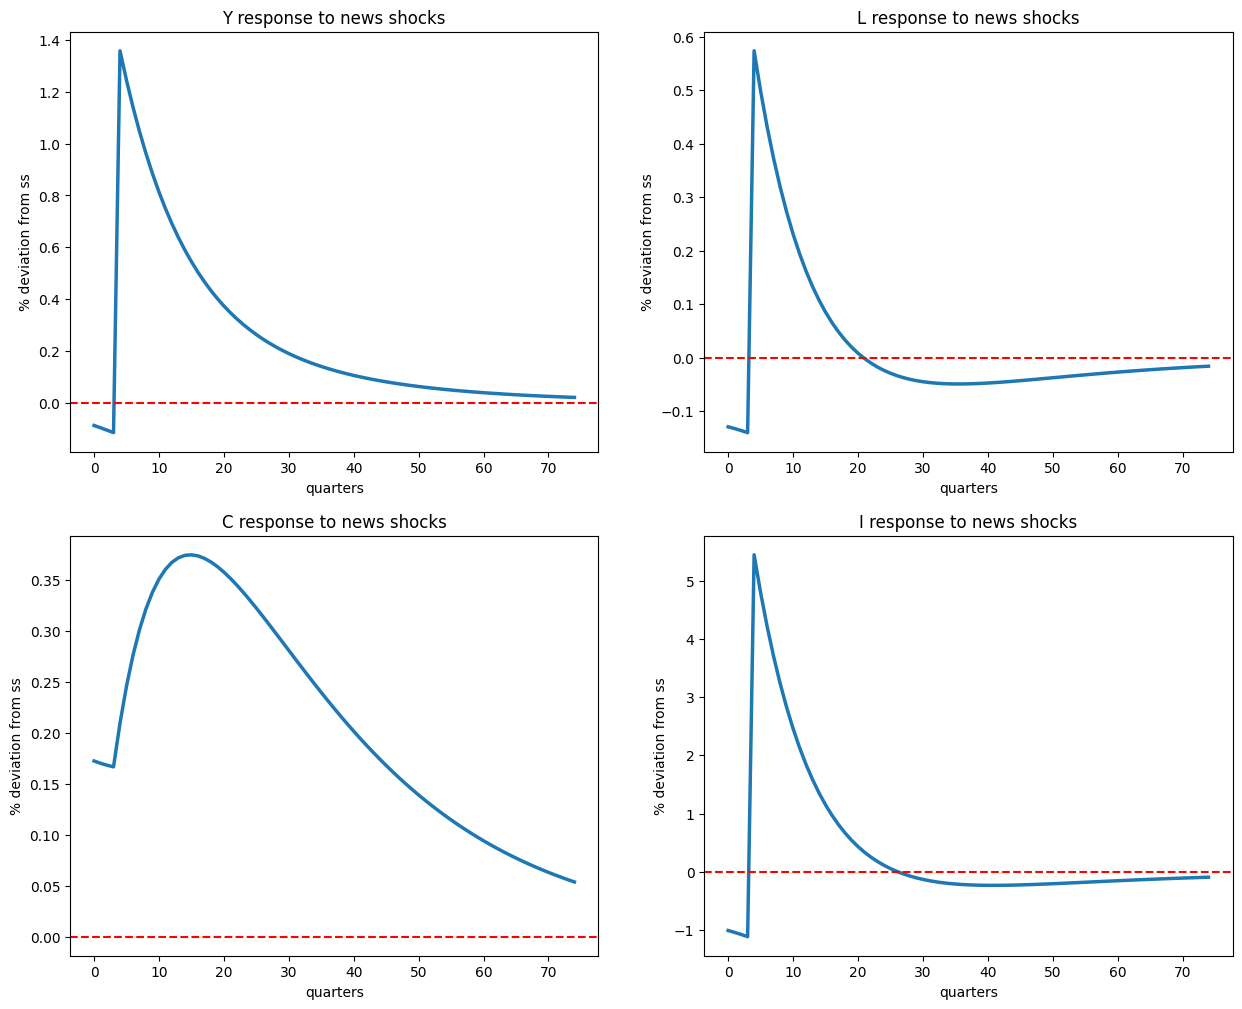

In [93]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)


for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_1b[var]['epsilon_news'] @ deps_news / ss_1b[var]
    
    ax = plt.subplot(2, 2, i + 1)

    ax.plot(dVal[:75], linewidth=2.5)
    ax.axhline(y = 0, linestyle = "--", color = "r")
    ax.set_title(f'{var} response to news shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

plt.show()

### Part 2b: Impulse Response Functions, Habit Formation

In [167]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@solved(unknowns={'I': (-5, 5)}, targets = ['I_eq'])
def household_invest(K, I, phi, delta):
    I_eq = (1-delta)*K(-1) + I - (phi/2) * ((I/K(-1) - delta) ** 2) * K(-1) - K
    return I_eq

@simple
def household_consumption(C, K, I, Z, L, kappa, beta, phi, delta, alpha):
    lambda_t = 1/(C - kappa*C(-1)) - beta*kappa/(C(+1) - kappa*C)
    lambda_t_plus_1 = 1/(C(+1) - kappa*C) - beta*kappa/(C(+2) - kappa*C(+1))
    
    q_t = 1/(1-phi*(I/K(-1) - delta))
    q_t_plus_1 = 1/(1-phi*(I(+1)/K - delta))
    
    r_t_plus_1 = alpha * Z(+1) * (K ** (alpha - 1)) * (L(+1) ** (1-alpha))
    mu_t = 1 - delta + phi*(I(+1)/K - delta) * I(+1)/K - phi/2 * (I(+1)/K - delta)
    
    C_eq = beta * lambda_t_plus_1/lambda_t * (r_t_plus_1 + q_t_plus_1 * mu_t) - q_t
    return C_eq
    
@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, euler, walras

@simple
def Z_process(Z, epsilon, epsilon_news, rho):
    epsilon_end = (Z).apply(np.log) - rho * (Z(-1)).apply(np.log) - epsilon_news(-4)
    epsilon_target = epsilon_end - epsilon
    return  epsilon_target 

In [168]:
kappa = 0.75
phi = 1.

In [169]:
rbc_2b = create_model([household_invest, household_consumption, firm, mkt_clearing, Z_process], name="RBC_2_2b")

calibration = {"Z": 1., "eis": EIS, "frisch": Frisch, "alpha": 0.33,"epsilon": 0., "epsilon_news": 0., "rho": rho, "delta" : 0.02, "b": b, "beta" : 0.99, "phi": 1., "kappa": 0.75}
unknowns_ss = {"K": 10., "L" : 0.33, "C": 1.}
targets_ss = {"goods_mkt": 0., "euler": 0., "C_eq": 0.}

ss_2b = rbc_2b.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")


inputs_2b = {"epsilon", "epsilon_news"}
unknowns_2b = {"K","L","Z","C"}
targets_2b = {"goods_mkt","walras","epsilon_target", "C_eq"}

G_2b = rbc_2b.solve_jacobian(ss_2b, unknowns_2b, targets_2b, inputs_2b, T=T)

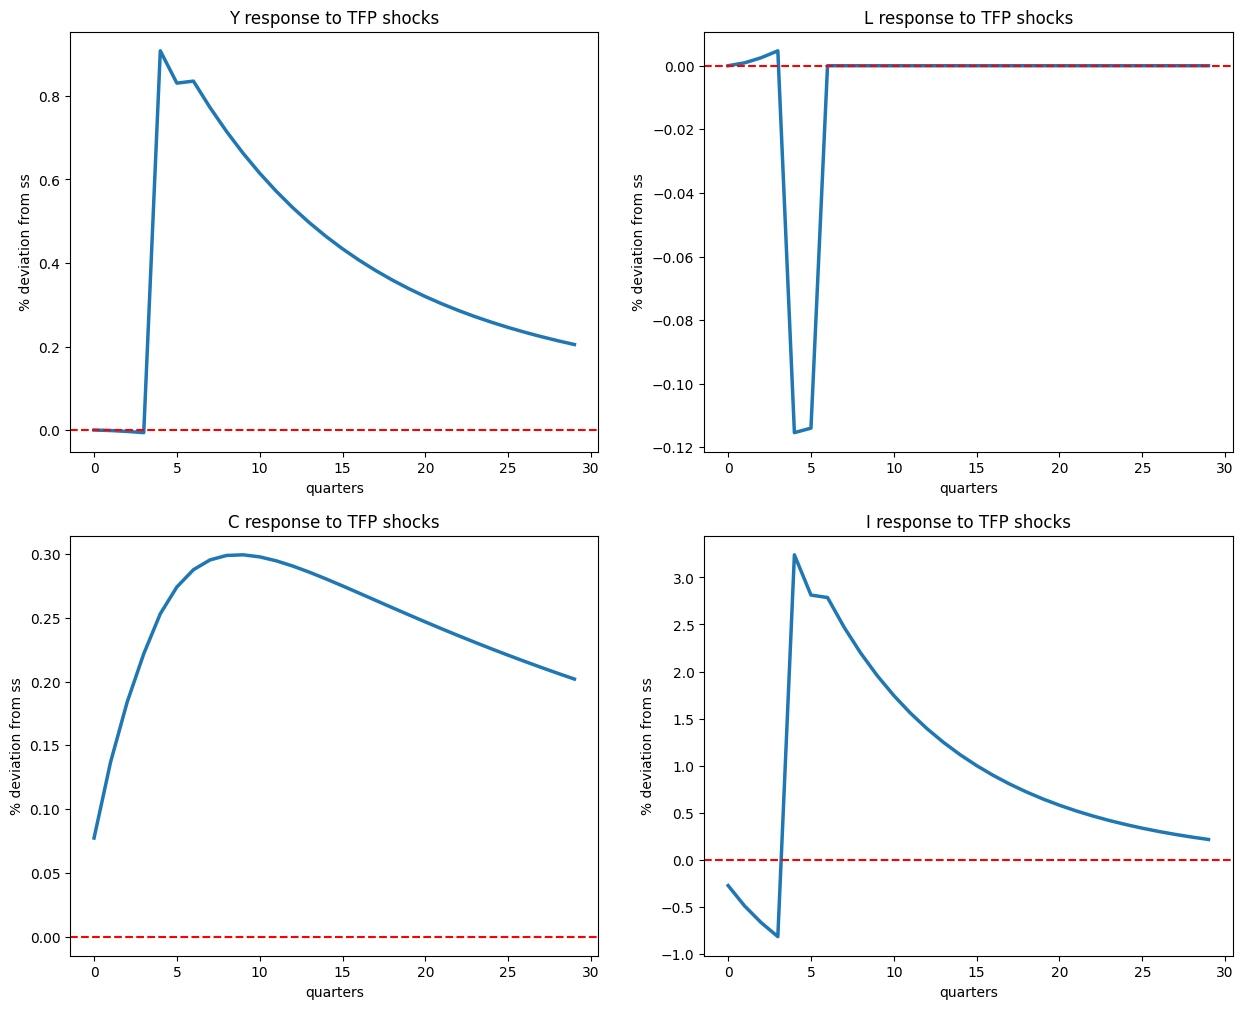

In [170]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)


for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_2b[var]['epsilon_news'] @ deps_news / ss_2b[var]
    
    ax = plt.subplot(2, 2, i + 1)

    ax.plot(dVal[:30], linewidth=2.5)
    ax.axhline(y = 0, linestyle = "--", color = "r")
    ax.set_title(f'{var} response to TFP shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

plt.show()

### Part 3b: Impulse Response Functions, Investment Growth Rate